# Employee attrition predictor
| COLUMN | DETAILS               |
|---------|-----------------------|
| Group   | B                     |
| Name    | Md. Shakhiul Abrar    |
| ID      | `2022-3-60-022`       |
| Section | 05                    |
| Course  | CSE303                |

-----

## Import nessesary libraries

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff

import kagglehub
from kagglehub import KaggleDatasetAdapter

from os import path
from sys import exit
import math

## A helper class to fetch the dataset
Returns `None` if fails to fetch

In [81]:
class DatasetLoader:
    def __init__(self):
        self.kaggle_url = "thedevastator/employee-attrition-and-factors"
        
        self.file_name = "HR_Analytics.csv.csv"
        self.dir_name = "dataset"
        
        self.file_path = path.join("..", self.dir_name, self.file_name)
        self.github_url = f'https://raw.githubusercontent.com/AbrarShakhi/employee-attrition-predictor/main/{self.dir_name}/{self.file_name}'
    
    def load_from_kaggle(self):
        try:
            return kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, self.kaggle_url, self.file_name)
        except:
            return None

    def load_from_github(self):
        try:
            return pd.read_csv(self.github_url)
        except:
            return None

    def load_from_local(self):
        try:
            return pd.read_csv(self.file_path)
        except:
            return None

## Fetch the dataset and show 5 rows
* fetch from local. in case of failure, fetch from `github`
* in case of failure, fetch from `kaggle`
* in case of failure, exit

In [82]:
loader = DatasetLoader()
data = loader.load_from_local()
if data is None:
    data = loader.load_from_github()
if data is None:
    data = loader.load_from_kaggle()
if data is None:
    print("Unable to find dataset..")
    exit(1)

data.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Number of null values in the dataset

In [83]:
print("total number of null values in dataset: ",
      sum(data.isnull().sum().to_numpy())
     )

total number of null values in dataset:  0


## although there is no NULL values, if there are, I whould delete them 

In [84]:
data = data.dropna()

## Shape of the dataset

In [85]:
data.shape

(1470, 35)

## Target column `Attrition`
value that we want to predict

In [86]:
target_column_name = "Attrition"
data[target_column_name].head()

0    Yes
1     No
2    Yes
3     No
4     No
Name: Attrition, dtype: object

## Check if the target column `Attrition` is balanced or not
since the target column boolean value, so we will use **PIE** chart

In [87]:
attrition_counts = data[target_column_name].value_counts().reset_index()
attrition_counts.columns = [target_column_name, 'Count']

fig = px.pie(attrition_counts, values='Count', names=target_column_name, 
             title='Attrition Pie chart', width=400, height=400)
fig.show()


## Remove columns that has only one value


In [88]:
for col in data.columns:
    if len(data[col].unique()) == 1:
        data.drop(col, axis=1, inplace=True)
        print(f"Removed column: {col}")

Removed column: EmployeeCount
Removed column: Over18
Removed column: StandardHours


## Split Nominal and Ordinal columns
and save them in a list

In [89]:
nominal_columns = []
ordinal_columns = []
other_columns = []

for col in data.columns:
    if data[col].dtype == "object":
        ordinal_columns.append(col)
    elif data[col].dtype != "int64" and data[col].dtype != "float64":
        other_columns.append(col)

for col in [
        "Attrition",
        "BusinessTravel",
        "Department",
        "EducationField",
        "EnvironmentSatisfaction",
        "Gender",
        "JobInvolvement",
        "JobLevel",
        "JobRole",
        "JobSatisfaction",
        "MaritalStatus",
        "OverTime",
        "PerformanceRating",
        "RelationshipSatisfaction",
        "WorkLifeBalance"
    ]:
    if col not in ordinal_columns:
        ordinal_columns.append(col)

for col in data.columns:
    if col not in ordinal_columns and col not in other_columns:
        if data[col].dtype != "object":
            nominal_columns.append(col)
        else:
            other_columns.append(col)

print("Nominal columns: ", nominal_columns)
print("Ordinal columns: ", ordinal_columns)
print("Other columns: ", other_columns)

print("Total nominal columns: ", len(nominal_columns))
print("Total ordinal columns: ", len(ordinal_columns))
print("Total other columns: ", len(other_columns))
print("Nominal + original + other columns: ", len(nominal_columns) + len(ordinal_columns) + len(other_columns))
print("Total columns: ", len(data.columns))

Nominal columns:  ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Ordinal columns:  ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']
Other columns:  []
Total nominal columns:  17
Total ordinal columns:  15
Total other columns:  0
Nominal + original + other columns:  32
Total columns:  32


## Functions that will print statistical values of columns
* Nominal column:
    - Mean
    - Median
    - Varience
    - Standared Deviation
* Ordinal column:
    - Frequency
    - Percentage

In [90]:
def print_nominal_info(col):
    print("Column name: ", col)
    print("Mean: ", data[col].mean())
    print("Median: ", data[col].median())
    print("Varience: ", data[col].var())
    print("Std-dev: ", data[col].std())

def print_ordinal_info(col):
    counts = data[col].value_counts()
    print(
        pd.DataFrame({
            "Frequency": counts,
            "Percentage": counts / len(data) * 100
        })
    )

## A quick info using a fucntion call for number type columns

In [91]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.00,3.0,4.00,4.0


## A quick info using a fucntion call for object type columns

In [92]:
data.describe(include="object").transpose()

,count,unique,top,freq
Attrition,1470,2,No,1233
BusinessTravel,1470,3,Travel_Rarely,1043
Department,1470,3,Research & Development,961
EducationField,1470,6,Life Sciences,606
Gender,1470,2,Male,882
JobRole,1470,9,Sales Executive,326
MaritalStatus,1470,3,Married,673
OverTime,1470,2,No,1054


## Dataset info for nominal columns

In [93]:
for col in nominal_columns:
    print_nominal_info(col)
    print()

Column name:  Age
Mean:  36.923809523809524
Median:  36.0
Varience:  83.45504878602223
Std-dev:  9.135373489136732

Column name:  DailyRate
Mean:  802.4857142857143
Median:  802.0
Varience:  162819.5937372362
Std-dev:  403.50909994352816

Column name:  DistanceFromHome
Mean:  9.19251700680272
Median:  7.0
Varience:  65.72125097826742
Std-dev:  8.106864435666074

Column name:  Education
Mean:  2.912925170068027
Median:  3.0
Varience:  1.0489138337431638
Std-dev:  1.0241649445978729

Column name:  EmployeeNumber
Mean:  1024.865306122449
Median:  1020.5
Varience:  362433.29974854476
Std-dev:  602.0243348474751

Column name:  HourlyRate
Mean:  65.89115646258503
Median:  66.0
Varience:  413.28562629953274
Std-dev:  20.329427593996165

Column name:  MonthlyIncome
Mean:  6502.931292517007
Median:  4919.0
Varience:  22164857.07151841
Std-dev:  4707.956783097994

Column name:  MonthlyRate
Mean:  14313.103401360544
Median:  14235.5
Varience:  50662878.16901497
Std-dev:  7117.786044059976

Column

## Dataset info for ordinal columns

In [94]:
for col in ordinal_columns:
    print_ordinal_info(col)
    print()

           Frequency  Percentage
Attrition                       
No              1233   83.877551
Yes              237   16.122449

                   Frequency  Percentage
BusinessTravel                          
Travel_Rarely           1043   70.952381
Travel_Frequently        277   18.843537
Non-Travel               150   10.204082

                        Frequency  Percentage
Department                                   
Research & Development        961   65.374150
Sales                         446   30.340136
Human Resources                63    4.285714

                  Frequency  Percentage
EducationField                         
Life Sciences           606   41.224490
Medical                 464   31.564626
Marketing               159   10.816327
Technical Degree        132    8.979592
Other                    82    5.578231
Human Resources          27    1.836735

        Frequency  Percentage
Gender                       
Male          882        60.0
Female        588  

## Convert catagorical data into numbers
`df` is original dataset,

`df_norm` is converted dataset

In [95]:
data_norm = pd.DataFrame(data)
def convert_categorical_to_numerical(col):
    return data_norm[col].astype("category").cat.codes

def convert_categorical_to_numerical_all(columns):
    for col in columns:
        if data_norm[col].dtype == "object":
            data_norm[col] = convert_categorical_to_numerical(col)
    return data_norm

convert_categorical_to_numerical_all(data_norm.columns)
data_norm

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,1,2,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,2,3,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,4,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,5,4,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,7,1,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,1,884,1,23,2,3,2061,3,...,3,3,1,17,3,3,5,2,0,3
1466,39,0,2,613,1,6,1,3,2062,4,...,3,1,1,9,5,3,7,7,1,7
1467,27,0,2,155,1,4,3,1,2064,2,...,4,2,1,6,0,3,6,2,0,3
1468,49,0,1,1023,2,2,3,3,2065,4,...,3,4,0,17,3,2,9,6,0,8


## histogram: `number of employees` in `Age` range group by `Attrition` color
### Age
The age of the employee. **Numerical**

In [96]:
fig = px.histogram(data, x="Age", color=target_column_name, barmode="group", )
fig.update_layout(title="Age Distribution", xaxis_title="Age", yaxis_title="number of employees", title_x=0.5)
fig.update_traces(opacity=0.75)
fig.update_traces(marker_line_width=1.5, marker_line_color="black")
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.show()


## Density HeatMap:`Age`, `Attrition`, `OverTime`, `TotalWorkingYears`

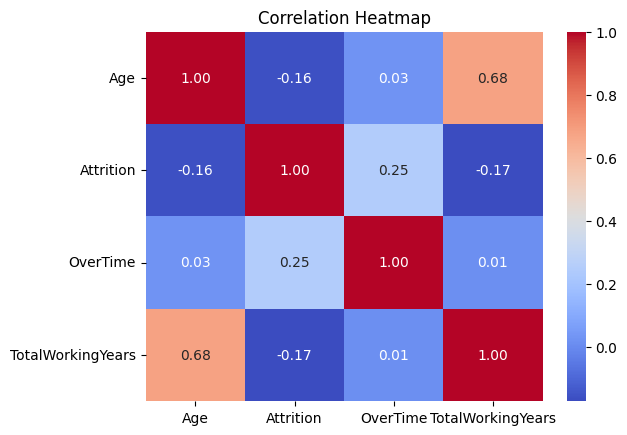

In [97]:
corr_mat= data_norm[["Age", "Attrition", "OverTime", "TotalWorkingYears"]].corr()

sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## Pie Chart

### BusinessTravel
The frequency of business travel for the employee. **Categorical**

In [98]:
business_travel_counts = data['BusinessTravel'].value_counts().reset_index()
business_travel_counts.columns = ['BusinessTravel', 'Count']

fig = px.pie(business_travel_counts, values='Count', names='BusinessTravel', 
             title='Business Travel Pie chart', width=400, height=400)
fig.show()

## Box Plot

### DailyRate
The daily rate of pay for the employee. **Numerical**

In [99]:
fig = px.box(data, x="DailyRate", title="Box plot of DailyRate")
fig.update_layout(xaxis_title="DailyRate", height=300, title_x=0.50)
fig.show()

## Histogram: Number of employee count in each `department` group by `Attrition`
### Department
The department the employee works in. **Categorical**

In [100]:
fig = px.histogram(data, x="Department", title="Department Histogram", color=target_column_name, barmode="group")
fig.update_layout(xaxis_title="Department", height=400, width=400)
fig.show()

## Dencity Carve of `Distance from home`
### DistanceFromHome
The distance from home in miles for the employee. **Numerical**

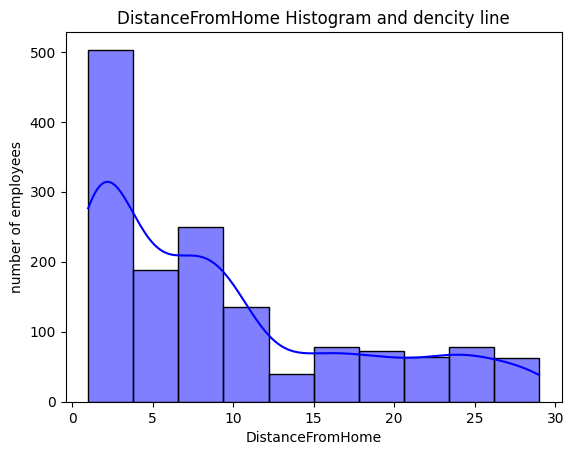

In [101]:

sns.histplot(data=data, x="DistanceFromHome", kde=True, color="blue", bins=10)
plt.title("DistanceFromHome Histogram and dencity line")
plt.ylabel("number of employees")
plt.show()


## 3D scatter plot: `Education`, `Age`, `EmployeeNumber`,
### Education
The level of education achieved by the employee. **Categorical**

In [102]:
fig = px.scatter_3d(
    data,
    x='Education',
    y='Age',
    z='EmployeeNumber',
    color='Attrition',
    opacity=0.5,
    title="3D Scatter plot of Education, Age and EmployeeNumber",
)
fig.update_layout(
    title_x=0.5
)
fig.show()

## Histogram: Number of employee count in each `Environment Satisfaction` level group by `Attrition`
### EnvironmentSatisfaction
The employee's satisfaction with their work environment. **Categorical**

In [103]:
px.histogram(
    data,
    x="EnvironmentSatisfaction",
    color=target_column_name,
    barmode="group"
).update_layout(
    title="Environment Satisfaction",
    width=300,
    height=300
).show()

## Histogram: Number of employee count in each `job Satisfaction` level group by `Attrition`

### JobSatisfaction
The employee's satisfaction with their job. **Categorical**

In [104]:
fig = px.histogram(data, x="JobSatisfaction", color=target_column_name, 
                   title="Job Satisfaction Histogram", barmode='group')
fig.update_layout(xaxis_title="Job Satisfaction", height=300, width=700)
fig.update_layout(title_text='Job Satisfaction vs number of employee', title_x=.5)
fig.update_traces(textfont_size=12)
fig.update_traces(textfont=dict(color="white"))
fig.show()


## Bar Chart: Total `Working Years` vs `Monthly Income` group by `Attrition`
### MonthlyIncome
The monthly income of the employee. **Numerical**

In [105]:
px.bar(
    data,
    x="TotalWorkingYears",
    y="MonthlyIncome",
    color=target_column_name,
    title="Total Working Years vs Monthly Income",
    barmode="group"
).update_layout(
    title_x=0.5,
    xaxis_title="Total Working Years",
    yaxis_title="Monthly Income"
).show()

## Correlation HeatMap Monthly Income vs Attrition

In [106]:
fig = px.density_heatmap(data, x="MonthlyIncome", y=target_column_name, color_continuous_scale="Viridis",)
fig.update_layout(title="Dencity Heamap with MonthlyIncome and Attrition", title_x=0.5)
fig.show()

## Scatter `Employee number` vs `Years At Company`
### YearsAtCompany
The number of years the employee has been with the company. **Numerical**

In [107]:
fig = px.scatter(
    data_norm,
    x='EmployeeNumber',
    y="YearsAtCompany",
    color=target_column_name,
    title='P',
    color_continuous_scale='viridis',
)
fig.update_layout(
    title="EmployeeNumber Vs YearsAtCompany With attrition"
)
fig.show()


## Violin diagram `StockOptionLevel` and `Attrition`
### StockOptionLevel
The stock option level of the employee. **Numerical**

In [108]:
fig = px.violin(
    data,
    y="StockOptionLevel",
    x=target_column_name,
    color=target_column_name,
    box=True,
    points="all",
    title="Stock Option Level vs Attrition"
)
fig.update_layout(
    title_x=0.5,
    xaxis_title="Attrition",
    yaxis_title="Stock Option Level"
)
fig.show()

## Line PLot: Employee number vs `YearsSinceLastPromotion`
### YearsSinceLastPromotion
The number of years since the employee's last promotion. **Numerical**

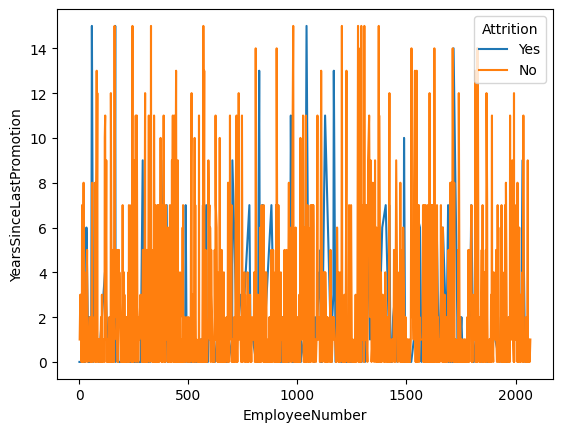

In [109]:
sns.lineplot(data=data, x="EmployeeNumber", y="YearsSinceLastPromotion", hue=target_column_name)
plt.show()

## Parallel Coordinates
Shows parallel coordinates graph for all nominal columns

In [110]:
fig = px.parallel_coordinates(
    data_norm,
    color=target_column_name,
    dimensions=nominal_columns,
    color_continuous_scale=px.colors.sequential.Aggrnyl,
    title="Parallel Coordinates Plot"
)
fig.update_layout(
    title_text="Parallel Coordinates Plot",
    title_x=0.5,
    # width=800,
    height=800
)
fig.show()

## Polar scatter plot
* radius: `Age`
* theta: `EmployeeNumber`
* color `Attrition`

In [111]:
px.scatter_polar(
    data,
    r="Age",
    theta="EmployeeNumber",
    color=target_column_name,
    title="Scatter Polar Plot",
    color_continuous_scale=px.colors.sequential.Inferno,
).update_layout(
    title_text="Scatter Polar Plot",
    title_x=0.5,
    width=800,
    height=600,
).show()



## Sankey diagram: `Attrition`, and `MaritalStatus`

In [112]:
columns = ['Attrition', 'MaritalStatus']

labels = pd.unique(data[columns].values.ravel('K')).tolist()

source = []
target = []
value = []

for i in range(len(columns) - 1):
    df_grouped = data.groupby([columns[i], columns[i+1]]).size().reset_index(name='count')
    for _, row in df_grouped.iterrows():
        source.append(labels.index(row[columns[i]]))
        target.append(labels.index(row[columns[i+1]]))
        value.append(row['count'])

link = dict(source=source, target=target, value=value)
node = dict(label=labels, pad=15, thickness=20, line=dict(color="black", width=0.5))

fig = go.Figure(go.Sankey(link=link, node=node, arrangement="snap", textfont=dict(size=10, color="black")))
fig.update_layout(title_text="Sankey Diagram of Attrition, and MaritalStatus", title_x=0.5)
fig.show()


## Pair plot `Age`, `DistanceFromHome`, `TotalWorkingYears`

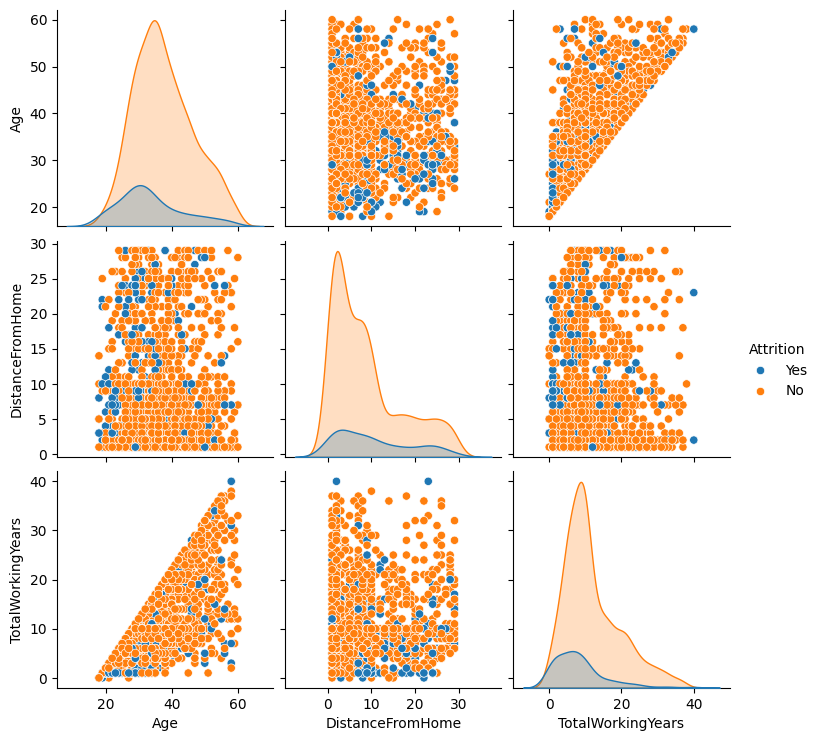

In [113]:
sns.pairplot(
    data,
    hue=target_column_name,
    vars=[
        "Age",
        "DistanceFromHome",
        "TotalWorkingYears"
    ],
    diag_kind="kde"
)
plt.show()

## Histogram: PercentSalaryHike, YearsSinceLastPromotion, TotalWorkingYears
The percentage of salary hike for the employee. **Numerical**

Year passed since last promotion **Numerical**

Total Working Years **Numerical**

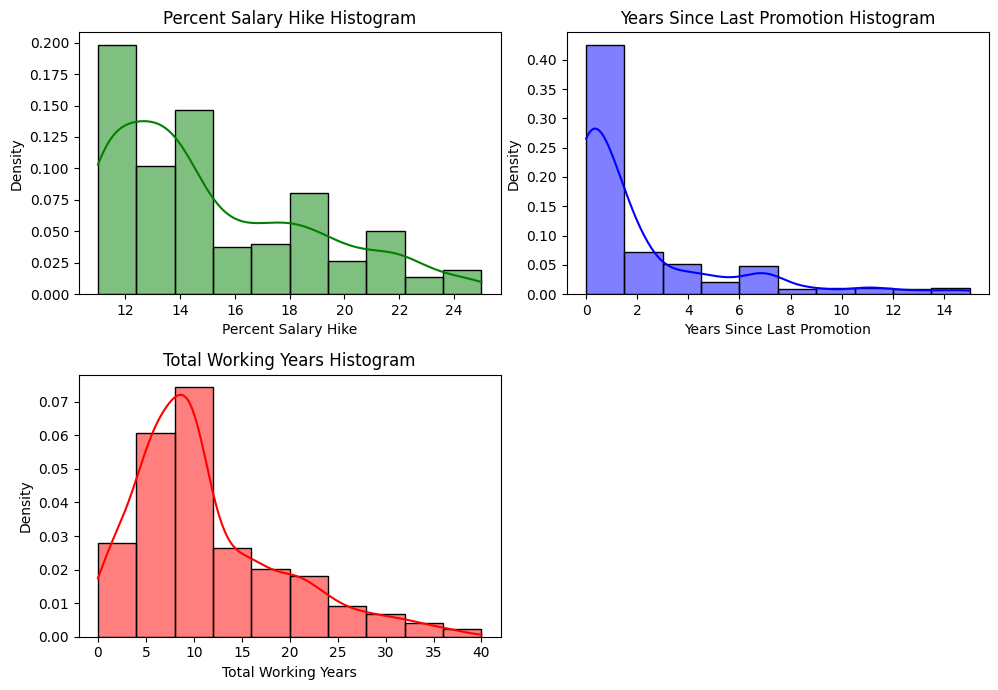

In [114]:
columns = ["PercentSalaryHike", "YearsSinceLastPromotion", "TotalWorkingYears"]
titles = ["Percent Salary Hike Histogram", "Years Since Last Promotion Histogram", "Total Working Years Histogram"]
xlabels = ["Percent Salary Hike", "Years Since Last Promotion", "Total Working Years"]
colors = ["g", "b", "r"]

plt.figure(figsize=(10, 7))
for i in range(len(columns)):
    plt.subplot(2, 2, i+1)
    sns.histplot(data[columns[i]], bins=10, color=colors[i], edgecolor='black', alpha=0.5, stat='density', kde=True)
    plt.title(titles[i])
    plt.xlabel(xlabels[i])
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


## Correlation HeatMap
Corralation heatmap with each column

In [115]:
corr_mat = data_norm.corr(method="pearson")
# corr_mat = df_norm.corr()

fig = go.Figure(
    data=go.Heatmap(
        z=corr_mat.values,
        x = corr_mat.columns,
        y = corr_mat.index,
        colorscale="Viridis",
    )
)
fig.update_layout(
    title="Correlation HeatMap",
    height=600,
    title_x=0.5,
)
fig.show()

## Correlation HeatMap with Attrition vs Every other column

In [116]:
corr_mat = data_norm.corr(method="pearson")
corr_mat = corr_mat[target_column_name].sort_values(ascending=False)
fig = px.bar(
    x=corr_mat.values,
    y=corr_mat.index,
    title="Correlation with Attrition",
    color=corr_mat.values,
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.update_layout(
    title_x=0.5,
    xaxis_title="Columns",
    yaxis_title="Correlation with Attrition",
    height=700
)
fig.show()